This notebook has some tests and tries to better understand the files generated by snudda, and the organization of info inside them.
when the functions are fully formed they are stored on the getData.py script, to be used as a library

In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from getData import *
#plt.scatter(self.time-skipTime,self.spikeID,color='black',s=1)

# 1) SYNAPSE-RELATED PLOTS (CONN PROB, MATRIX...)
## 1.1) NETWORK-PRUNED-SYNAPSES.HDF5
 Exploring the file to understand the organization of the data inside, so we can collect all the info we need for the plots 

In [35]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/network-pruned-synapses.hdf5', 'r') as file:
    network = file.get('network')
    synapses = network.get('synapses')
    neurons = network.get('neurons')
    neuronID = np.array(neurons.get('neuronID'))
    morphology = np.array(neurons.get('morphology'))
    
    syn_table = []
    for i in range(0,len(synapses)):
        syn_table.append(synapses[i])

    df2 = pd.DataFrame(data=syn_table)
    df2.columns = ['sourceID', 'destinID', '3', '4', '5', 'synapseType', '7', 'dentDistance', '9', '10', '11', '12', '13']
    print(df2)    

      sourceID  destinID    3    4    5  synapseType   7  dentDistance    9  \
0            3         0   75  136  199            6  14           240  143   
1            3         0   91  132  211            7  14           260  107   
2            3         0  111  136  185           26  14           192   40   
3            6         0  117  116  178           26  14           366  115   
4            6         0  128  118  167           26  14           289  130   
...        ...       ...  ...  ...  ...          ...  ..           ...  ...   
7029        89        98  142  104  186           26  14           223   92   
7030        89        98  159  135  187           26  14           312   53   
7031        92        98  135   94  176           21  14           239  136   
7032        92        98  135   98  177           21  14           149  120   
7033        92        98  136   98  177           21  14           156  122   

      10   11   12      13  
0      5  960  191  55

## 1.2) FUNCTIONS
Some of the functions that are needed to generate the plots. there are still some missing

In [38]:
import math
            
#Function to find distance => useful for the connection probability plots -> needs to be modified still
def distance(coord1, coord2):
      
    d = math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1]) **2 + (coord2[2] - coord1[2])**2)
    return(d)

def getSynapses(path):
    
    with h5py.File('/home/ubuntu/Snudda/networks/tinySim/network-pruned-synapses.hdf5', 'r') as file:
        synapses = file.get('network').get('synapses')

        syn_table = []
        for i in range(0,len(synapses)):
            syn_table.append([synapses[i][0], synapses[i][1]]) #Pre_ID | Pos_ID

    return(syn_table)  

## THIS CELL AS WELL. TURN IT INTO A FUNCTION -> that provides the distance between somas
#def DistanceMatrix(positions) :

getNeuronPositions('blabla')
synaptic_table = getSynapses('v')
distance_matrix = []

for i in range (0, len(neuron_positions)):   
    for j in range(0, len(neuron_positions)):
        
        #calculate the distance here
        coord_pre = neuron_positions[i]
        coord_pos = neuron_positions[j]
        #just a boolean, 1 for existing connection, 0 to no connection
        #can be replaced with a function that returns the # of synapses between the given pre pos pair
        if ([i,j] in syn_table):
            synapse = 1
        else :
            synapse = 0        
        distance_matrix.append([i,j,distance(coord_pre, coord_pos), synapse])

df4 = pd.DataFrame(data=distance_matrix)
df4.columns = ['ID_pre', 'ID_pos', 'SomaticDistance', 'Synapse']
print(df4)

In [49]:
#this command selects from the df only the neuron pairs where there is a synapse between them

syn1 = df4[df4["Synapse"] == 1]
print(syn1)

      ID1  ID2  SomaticDistance  Synapse
14      0   14         0.000079        1
30      0   30         0.000092        1
53      0   53         0.000104        1
54      0   54         0.000067        1
61      0   61         0.000116        1
...   ...  ...              ...      ...
9784   98   82         0.000039        1
9787   98   85         0.000016        1
9793   98   91         0.000086        1
9794   98   92         0.000050        1
9799   98   97         0.000077        1

[2005 rows x 4 columns]


# 2) PREPARATION OF THE INPUT INFO

We need to transform the information about the snudda generated input into a new input, compatible with the NEST simulator. 
STEP BY STEP OF THE TRANSFORMATION:
- open hdf5 file and gather all spikes in one array (each neuron gets 3 input_spikes array: basal, signal and thalamic)
- merge all 3 arrays into a single one. chenge the time of spikes from s to ms. organize in crescent order
    - done, we have the first most basic input to be used.
- import as well the conductance values, calculate the mean value of the diff inputs conductances
    - to understand if there is a significant difference, and we should use 3 arrays and 3 input generators insted of only 1


## 2.1) INPUT-SPIKES.HDF5 FILE

In [36]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    print("Input hdf5 file contents:")
    print(list(file.keys()))
    
    inputs = file.get('input')
    print("\n 'input' is divided by neuron #")
    print(list(inputs.keys()))
    
    neuron_0 = inputs.get('0')
    print("\n 3 different signals for each neuron")
    print(list(neuron_0.keys()))
    
    CorticalBase_0 = neuron_0.get("CorticalBase")
    CorticalSignal_0 = neuron_0.get("CorticalSignal")
    Thalamic_0 = neuron_0.get("Thalamic")
    
    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    
    print("\n start time should be 0")
    print(np.array(CorticalBase_0.get('start')))
    print("\n end time should be 2")
    print(np.array(CorticalBase_0.get('end')))    
    
    print("\n n spikes holds the # of spikes present in each row of the spikes matrix (so has the same length as spikes). this doesn't seem useful for us atm")
    print(np.array(CorticalBase_0.get('nSpikes')))
    
    print("\n spikes holds values from start to end when a spike hits the neuron, and -1 represents null")    
    print(np.array(CorticalBase_0.get('spikes')))
    
    print("\n Cortical Base Conductance: ", np.array(CorticalBase_0.get('conductance')))    
    print("\n Cortical Signal Conductance: ", np.array(CorticalSignal_0.get('conductance')))    
    print("\n Thalamic Conductance: ", np.array(Thalamic_0.get('conductance')))    

    #this could have info to add later on
    #print("\n Cortical Base Parameter List: ", np.array(CorticalBase_0.get('parameterList')))


Input hdf5 file contents:
['config', 'input']

 'input' is divided by neuron #
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98']

 3 different signals for each neuron
['CorticalBase', 'CorticalSignal', 'Thalamic']

 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start'

So here I realized not all the neurons have the same input types.

In [37]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    inputs = file.get('input')
    print("\n 'input' is divided by neuron #")
    print(list(inputs.keys()))
    
    for i in range(0, 99):
        a = str(i)
        neuron_i = inputs.get(a)
        message = "\n signals for  neuron" + a
        print(message)
        print(list(neuron_i.keys()))


 'input' is divided by neuron #
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98']

 signals for  neuron0
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron1
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron2
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron3
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron4
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron5
['Cortica

In [42]:
neuron_matrix = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

In [43]:
print(neuron_matrix)

[[0, 'dspn'], [1, 'ispn'], [2, 'dspn'], [3, 'dspn'], [4, 'ispn'], [5, 'ispn'], [6, 'dspn'], [7, 'ispn'], [8, 'ispn'], [9, 'dspn'], [10, 'ispn'], [11, 'ispn'], [12, 'ispn'], [13, 'dspn'], [14, 'ispn'], [15, 'dspn'], [16, 'dspn'], [17, 'dspn'], [18, 'dspn'], [19, 'ispn'], [20, 'ispn'], [21, 'dspn'], [22, 'ispn'], [23, 'dspn'], [24, 'dspn'], [25, 'dspn'], [26, 'ispn'], [27, 'ispn'], [28, 'ispn'], [29, 'ispn'], [30, 'dspn'], [31, 'dspn'], [32, 'ispn'], [33, 'ispn'], [34, 'ispn'], [35, 'dspn'], [36, 'ispn'], [37, 'dspn'], [38, 'dspn'], [39, 'ispn'], [40, 'dspn'], [41, 'dspn'], [42, 'ispn'], [43, 'dspn'], [44, 'dspn'], [45, 'ispn'], [46, 'ispn'], [47, 'ispn'], [48, 'ispn'], [49, 'dspn'], [50, 'ispn'], [51, 'ispn'], [52, 'ispn'], [53, 'ispn'], [54, 'dspn'], [55, 'ispn'], [56, 'fs'], [57, 'ispn'], [58, 'ispn'], [59, 'dspn'], [60, 'ispn'], [61, 'dspn'], [62, 'dspn'], [63, 'ispn'], [64, 'ispn'], [65, 'ispn'], [66, 'dspn'], [67, 'dspn'], [68, 'ispn'], [69, 'ispn'], [70, 'dspn'], [71, 'dspn'], [72

In [45]:
dspn, ispn, lts, fs, chin = getNeuronSubMatrixes(neuron_matrix)
print(lts)
print(fs)
print(chin)

[87]
[56]
[79]


Looking more throughly into the conductances, to see if they are all really the same. For all DSPN and ISPN inputs (signal base and thalamic) -> the conductance is always 5e-10

In [61]:
conduct = np.full((1), 0.0000000005)
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    interneurons = [56,79,87]
    inputs = file.get('input')
    print("\n 'input' is divided by neuron #")
    print(list(inputs.keys()))
    
    for i in range(0, 99):
        
        if i not in interneurons: 
            a = str(i)
            neuron_i = inputs.get(a)
            
            message = "\n signals for  neuron" + a
            print(message)
            print(list(neuron_i.keys()))
            
            CorticalBase_i = neuron_i.get("CorticalBase")
            CorticalSignal_i = neuron_i.get("CorticalSignal")
            Thalamic_i = neuron_i.get("Thalamic")
            
            
            if (np.array(CorticalBase_i.get('conductance'))!= conduct):
                print("\n Cortical Base Conductance: ", np.array(CorticalBase_i.get('conductance')))
                
            if (np.array(CorticalSignal_i.get('conductance'))!= conduct):
                print("\n Cortical Signal Conductance: ", np.array(CorticalSignal_i.get('conductance')))
                
            if (np.array(Thalamic_i.get('conductance'))!= conduct):
                print("\n Thalamic Conductance: ", np.array(Thalamic_i.get('conductance')))    




 'input' is divided by neuron #
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98']

 signals for  neuron0
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron1
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron2
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron3
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron4
['CorticalBase', 'CorticalSignal', 'Thalamic']

 signals for  neuron5
['Cortica

In [64]:
conduct = np.full((1), 0.0000000005)
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    interneurons = [56,79,87]
    inputs = file.get('input')
    print("\n 'input' is divided by neuron #")
    print(list(inputs.keys()))
    
    for i in interneurons:
        
        a = str(i)
        neuron_i = inputs.get(a)

        #synapses = file.get('network').get('synapses')
        
        message = "\n signals for  neuron" + a
        key_list = list(neuron_i.keys())
        print(message)
        print(list(neuron_i.keys()))
        
        for key in key_list:
            message = str(key) + 'Conductance'
            print(message, np.array(neuron_i.get(key).get('conductance')))



 'input' is divided by neuron #
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98']

 signals for  neuron56
['Cortical', 'CorticalSignal', 'Thalamic']
CorticalConductance 1.5e-09
CorticalSignalConductance 1.5e-09
ThalamicConductance 1.5e-09

 signals for  neuron79
['Cortical', 'Thalamic']
CorticalConductance 5e-10
ThalamicConductance 5e-10

 signals for  neuron87
['Cortical', 'CorticalSignal']
CorticalConductance 5e-11
CorticalSignalConductance 5e-11


CHECKLIST FOR INPUT PREPARATION:
- for each neuron:
    - remove -1 values
    - convert from s to ms
    - compile matrix into simple arrays
    - sort the array in crescent order
    - round the spike times to only 1 decimal (more resolution than that caused an error on the spike generator)
- create matrix (list of list) where : row = neuronID and values in row = input spike times for that ID
- create spike generators, one for each neuron, with the correspondent row of spike times

In [33]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    size = 3
    inputs = file.get('input')
    final_input = []
    
    for i in range(0, size):
        a = str(i)
        aux_input = []
        
        cortical_base = np.array(inputs.get(a).get("CorticalBase").get('spikes'))
        cortical_signal = np.array(inputs.get(a).get("CorticalSignal").get('spikes'))
        thalamic = np.array(inputs.get(a).get("Thalamic").get('spikes'))
        
        for line in cortical_base:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)

        for line in cortical_signal:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)
                    
        for line in thalamic:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)
        
        aux_input.sort()
        final_input.append(np.around(aux_input, decimals = 1))
 

[8.393565931973043, 11.657406139411497, 13.758586974110365, 14.399215328488932, 14.548529533374214, 16.025659369829935, 17.06232256781037, 18.809946554244647, 20.202193071660023, 22.26545169405924, 23.0391213740407, 24.12772427809385, 39.24743039666868, 43.397695490562256, 44.57425332316814, 46.048019203298594, 52.597035981078434, 53.161011384480084, 56.85602576289613, 59.43605020423893, 61.52413675339931, 64.21899378853523, 70.42254025036436, 75.21828217259252, 76.18887819302824, 78.51462415279711, 82.50722563980331, 84.79500671896432, 85.07547985489542, 86.68767907302757, 89.08428300367558, 89.10464335280537, 92.00155457788455, 92.3923620065211, 93.82941097421858, 95.4960681821335, 95.54377399695395, 98.98464810958906, 103.73909299660079, 117.36007113444403, 123.81564385057122, 126.87344260647421, 128.10346526907034, 132.17065618571155, 134.2469965773425, 136.60703100561787, 136.74026964785185, 145.00500839235212, 147.7162574173628, 148.12076651752457, 149.72821685159292, 151.1958244

In [ ]:
''' JUST A TEST TO SHOW THAT THE INPUT MATRIX HAS WORKED, MATCHES THE #OF SPIKES FROM THE HDF5
    print(len(final_input))
    print("Obtained number of spikes to neuron 0", len(final_input[0]))
    print(len(final_input[1]))

    CB_Spikes_0 = np.array(inputs.get(a).get("CorticalBase").get('nSpikes'))
    CS_Spikes_0 = np.array(inputs.get(a).get("CorticalSignal").get('nSpikes'))
    T_Spikes_0 = np.array(inputs.get(a).get("Thalamic").get('nSpikes'))
    
    total = 0
    for num  in CB_Spikes_0:
        total += num
    for num  in CS_Spikes_0:
        total += num
    for num  in T_Spikes_0:
        total += num        
 
    print("Calculated number of spikes to neuron 0 from the hdf5 info : ", total)

'''

In [4]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    inputs = file.get('input')
    input_matrix = []
    
    neuronID = str(61)

    neuron_i = inputs.get(neuronID)
    input_neuron_i = []

    source_list = list(neuron_i.keys())

    for source in source_list:
        spike_train = np.array(neuron_i.get(source).get('spikes'))

        for line in spike_train:

            for spike_time in line:

                if (spike_time!=-1):              
                    input_neuron_i.append(np.ceil((spike_time*1000) * 10) / 10)
                  
    input_neuron_i.sort()    
    input_matrix.append(input_neuron_i)
    


0.1


In [5]:
print(input_neuron_i[0])
print(input_matrix[0][0])

print(input_neuron_i[1])
print(input_matrix[0][1])

0.1
0.1
0.7
0.7


In [93]:
number = 0.6361824996456988
factor = 10
print(np.around(number, decimals=1))
print(np.ceil(number * 10) / 10)

0.6
0.7


In [11]:
neuron_matrix = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

dspn, ispn, lts, chin, fs = getNeuronSubMatrixes(neuron_matrix)

input_matrix = getInput('net_100', 100)

dspn_avg = 0
for neuron in dspn:
    dspn_avg += len(input_matrix[neuron])
dspn_avg = dspn_avg/(len(dspn))
print("dspn spike avg:", dspn_avg)

ispn_avg = 0
for neuron in ispn:
    ispn_avg += len(input_matrix[neuron])
ispn_avg = ispn_avg/(len(ispn))
print("ispn spike avg:", ispn_avg)

chin_avg = 0
for neuron in chin:
    chin_avg += len(input_matrix[neuron])
chin_avg = chin_avg/(len(chin))
print("chin spike avg:", chin_avg)

lts_avg = 0
for neuron in lts:
    lts_avg += len(input_matrix[neuron])
lts_avg = lts_avg/(len(lts))
print("lts spike avg:", lts_avg)

fs_avg = 0
for neuron in fs:
    fs_avg += len(input_matrix[neuron])
fs_avg = fs_avg/(len(fs))
print("fs spike avg:", fs_avg)

dspn spike avg: 729.3125
ispn spike avg: 576.0416666666666
chin spike avg: 895.0
lts spike avg: 0.0
fs spike avg: 418.0


In [63]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    neuron_0 = inputs.get('0')
    CorticalBase_0 = neuron_0.get("CorticalBase")

    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    print()
    

    #print(np.array(CorticalBase_0.get('nSpikes')))
    
    input_matrix = []
    syn_den_list = []
    
    print("synaptic density values (functions):")
    
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        input_neuron_i = []

        source_list = list(neuron_i.keys())

        for source in source_list:
            syn_den = np.array(neuron_i.get(source).get('synapseDensity'))
            if syn_den not in syn_den_list:
                syn_den_list.append(syn_den)
                print(neuron_matrix[num], ", ", source, ": ", syn_den, "\n")

                
    print(len(syn_den_list))
    

#     input_matrix.append(input_neuron_i)'''
                
    #this could have info to add later on
    #print("\n Cortical Base Parameter List: ", np.array(CorticalBase_0.get('parameterList')))


 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start', 'synapseDensity']

synaptic density values (functions):
[0, 'dspn'] ,  CorticalBase :  0.05/(1+np.exp(-(d-30e-6)/5e-6)) 

[0, 'dspn'] ,  Thalamic :  0.05*np.exp(-d/200e-6) 

[1, 'ispn'] ,  CorticalBase :  0.052/(1+np.exp(-(d-30e-6)/5e-6)) 

[1, 'ispn'] ,  Thalamic :  0.052*np.exp(-d/200e-6) 

[56, 'fs'] ,  Cortical :  0.073*(1-np.exp(-d/200e-6)) 

[56, 'fs'] ,  Thalamic :  0.073*np.exp(-d/200e-6) 

[79, 'chin'] ,  Cortical :  0.03*(1-np.exp(-d/200e-6)) 

[79, 'chin'] ,  Thalamic :  0.03*np.exp(-d/200e-6) 

[87, 'lts'] ,  Cortical :  0.001*(1-np.exp(-d/200e-6)) 

9


In [58]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    neuron_0 = inputs.get('0')
    CorticalBase_0 = neuron_0.get("CorticalBase")

    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    print()
    

    #print(np.array(CorticalBase_0.get('nSpikes')))
    
    input_matrix = []
    syn_den_list = []
    id_list = [0,1,2,4,56,79,87]
    for num in id_list:
        neuronID = str(num)

        neuron_i = inputs.get(neuronID)

        source_list = list(neuron_i.keys())

        for source in source_list:
            syn_den = np.array(neuron_i.get(source).get('synapseDensity'))
            print(neuron_matrix[num], ", ", source, ": ", syn_den, "\n")



 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start', 'synapseDensity']

[0, 'dspn'] ,  CorticalBase :  0.05/(1+np.exp(-(d-30e-6)/5e-6)) 

[0, 'dspn'] ,  CorticalSignal :  0.05/(1+np.exp(-(d-30e-6)/5e-6)) 

[0, 'dspn'] ,  Thalamic :  0.05*np.exp(-d/200e-6) 

[1, 'ispn'] ,  CorticalBase :  0.052/(1+np.exp(-(d-30e-6)/5e-6)) 

[1, 'ispn'] ,  CorticalSignal :  0.052/(1+np.exp(-(d-30e-6)/5e-6)) 

[1, 'ispn'] ,  Thalamic :  0.052*np.exp(-d/200e-6) 

[2, 'dspn'] ,  CorticalBase :  0.05/(1+np.exp(-(d-30e-6)/5e-6)) 

[2, 'dspn'] ,  CorticalSignal :  0.05/(1+np.exp(-(d-30e-6)/5e-6)) 

[2, 'dspn'] ,  Thalamic :  0.05*np.exp(-d/200e-6) 

[4, 'ispn'] ,  CorticalBase :  0.052/(1+np.exp(-(d-30e-6)/5e-6)) 

[4, 'ispn'] ,  CorticalSignal :  0.052/(1+np.exp(-(d-30e-6)/5e-6)) 

[4, 'ispn'] ,  Thalamic :  0.05

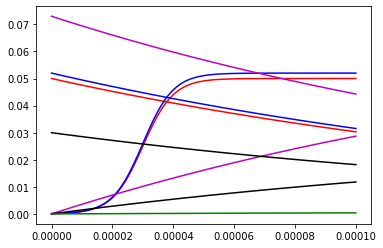

In [54]:
d = np.linspace(0, 0.00010, 100)
colors = ['r','r','b', 'b', 'm', 'm', 'k','k', 'g']
fctn = [0.05/(1+np.exp(-(d-30e-6)/5e-6)), 0.05*np.exp(-d/200e-6), 0.052/(1+np.exp(-(d-30e-6)/5e-6)), 0.052*np.exp(-d/200e-6),
       0.073*(1-np.exp(-d/200e-6)), 0.073*np.exp(-d/200e-6), 0.03*(1-np.exp(-d/200e-6)),  0.03*np.exp(-d/200e-6),0.001*(1-np.exp(-d/200e-6)) ]

for i in range(0, len(fctn)):
    plt.plot(d, fctn[i], colors[i]) # plotting t, a separately 
    
plt.show()

In [64]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    neuron_0 = inputs.get('0')
    CorticalBase_0 = neuron_0.get("CorticalBase")

    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    print()
    

    #print(np.array(CorticalBase_0.get('nSpikes')))
    
    input_matrix = []
    corr_list = []
    print("correlation values")
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        input_neuron_i = []

        source_list = list(neuron_i.keys())
        for source in source_list:
            corr = np.array(neuron_i.get(source).get('correlation'))
            if corr not in corr_list:
                corr_list.append(corr)
                print(neuron_matrix[num], ", ", source, ": ", corr, "\n")
    


 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start', 'synapseDensity']

correlation values
[0, 'dspn'] ,  CorticalBase :  0.0 



In [75]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    neuron_0 = inputs.get('0')
    CorticalBase_0 = neuron_0.get("CorticalBase")

    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    print()
    

    #print(np.array(CorticalBase_0.get('nSpikes')))
    
    input_matrix = []
    id_list = [0,1,56,79,87]

    
    print("channel spikes values")
    for num in id_list:

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)

        source_list = list(neuron_i.keys())
        for source in source_list:
            chan_spk = np.array(neuron_i.get(source).get('channelSpikes'))
            print(neuron_matrix[num], ", ", source, ": ", chan_spk, "\n")




 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start', 'synapseDensity']

channel spikes values
[0, 'dspn'] ,  CorticalBase :  [] 

[0, 'dspn'] ,  CorticalSignal :  [1.25768969 1.55129284 1.87709858] 

[0, 'dspn'] ,  Thalamic :  [0.21018202 1.79999066] 

[1, 'ispn'] ,  CorticalBase :  [1.43028044] 

[1, 'ispn'] ,  CorticalSignal :  [0.87114574 1.32565961 1.74178286] 

[1, 'ispn'] ,  Thalamic :  [0.44335688 0.77692441] 

[56, 'fs'] ,  Cortical :  [0.14440012] 

[56, 'fs'] ,  CorticalSignal :  [1.04733873 1.1163364  1.71184261] 

[56, 'fs'] ,  Thalamic :  [] 

[79, 'chin'] ,  Cortical :  [1.53014228 1.91764723] 

[79, 'chin'] ,  Thalamic :  [] 

[87, 'lts'] ,  Cortical :  [1.29223166 1.54524403 1.8089434 ] 

[87, 'lts'] ,  CorticalSignal :  [0.58008682 0.88315315] 



In [69]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    neuron_0 = inputs.get('0')
    CorticalBase_0 = neuron_0.get("CorticalBase")

    print("\n EACH SIGNAL HAS THE FOLLOWING PARAMS")
    print(list(CorticalBase_0.keys()))
    print()
    

    #print(np.array(CorticalBase_0.get('nSpikes')))
    
    input_matrix = []
    chan_spk_list = []
    
    dspn_cbase = []
    dspn_csig = []
    dspn_thal = []
    ispn_cbase = []
    ispn_csig = []
    ispn_thal = []
    chin_cbase = []
    chin_thal = []
    lts_cbase = []
    lts_csig = []
    fs_cbase = []
    fs_csig = []
    fs_thal = []
    
    print("channel spikes values")
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        aux_chan_spk = []

        source_list = list(neuron_i.keys())
        for source in source_list:
            chan_spk = np.array(neuron_i.get(source).get('channelSpikes'))
            aux_chan_spk.append(chan_spk)
        chan_spk_list.append(aux_chan_spk)
    
for i in range(0, len(chan_spk_list)):
    if i in dspn:
        dspn_cbase.append(chan_spk_list[i][0])
        dspn_csig.append(chan_spk_list[i][1])
        dspn_thal.append(chan_spk_list[i][2])

    if i in ispn:
        ispn_cbase.append(chan_spk_list[i][0])
        ispn_csig.append(chan_spk_list[i][1])
        ispn_thal.append(chan_spk_list[i][2])
        
    if i in chin:
        chin_cbase.append(chan_spk_list[i][0])
        chin_thal.append(chan_spk_list[i][1])
        
    if i in lts:
        lts_cbase.append(chan_spk_list[i][0])
        lts_csig.append(chan_spk_list[i][1])
        
    if i in fs:
        fs_cbase.append(chan_spk_list[i][0])
        fs_csig.append(chan_spk_list[i][1])
        #fs_thal.append(chan_spk_list[i][2])
        
    


 EACH SIGNAL HAS THE FOLLOWING PARAMS
['channelID', 'channelSpikes', 'conductance', 'correlation', 'end', 'freq', 'generator', 'jitter', 'modFile', 'nSpikes', 'parameterFile', 'parameterID', 'parameterList', 'sectionID', 'sectionX', 'spikes', 'start', 'synapseDensity']

channel spikes values


In [74]:
for i in range(0, len(ispn_thal)):
    print(ispn_thal[i])

[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77692441]
[0.44335688 0.77

In [76]:
dspn_chan_spk_avg = 0
for neuron in dspn:
    dspn_avg += len(input_matrix[neuron])
dspn_avg = dspn_avg/(len(dspn))
print("dspn spike avg:", dspn_avg)

ispn_avg = 0
for neuron in ispn:
    ispn_avg += len(input_matrix[neuron])
ispn_avg = ispn_avg/(len(ispn))
print("ispn spike avg:", ispn_avg)

chin_avg = 0
for neuron in chin:
    chin_avg += len(input_matrix[neuron])
chin_avg = chin_avg/(len(chin))
print("chin spike avg:", chin_avg)

lts_avg = 0
for neuron in lts:
    lts_avg += len(input_matrix[neuron])
lts_avg = lts_avg/(len(lts))
print("lts spike avg:", lts_avg)

fs_avg = 0
for neuron in fs:
    fs_avg += len(input_matrix[neuron])
fs_avg = fs_avg/(len(fs))
print("fs spike avg:", fs_avg)

IndexError: list index out of range

In [93]:
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    neuron87 = file.get('input').get('87')
    print(list(neuron87.keys()))
    nspikes_cort = np.array(neuron87.get('Cortical').get('nSpikes'))
    nspikes_cortsig = np.array(neuron87.get('CorticalSignal').get('nSpikes'))
    print(nspikes_cort)
    print(nspikes_cortsig)
    

    

['Cortical', 'CorticalSignal']
0
0


In [95]:
neuron_matrix = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

dspn_index, ispn_index, lts_index, chin_index, fs_index = getNeuronSubMatrixes(neuron_matrix)


with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    num_syn_list = []

    dspn = 0
    ispn =0
    fs = 0
    chin = 0
    lts = 0 
    dspn_list = []
    ispn_list =[]
    fs_list =[]
    chin_list =[]
    lts_list = []
    
    print("number of synapses")
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        aux_synapse = 0

        source_list = list(neuron_i.keys())

        for source in source_list:
            if num == 87:
                aux_synapse = 0
            else: 
                aux_synapse= aux_synapse + len(np.array(neuron_i.get(source).get('nSpikes')))
        num_syn_list.append(aux_synapse)
    
for i in range(0, len(num_syn_list)):
    if i in dspn_index:
        dspn_list.append(num_syn_list[i])
        dspn = dspn + num_syn_list[i]

    if i in ispn_index:
        ispn_list.append(num_syn_list[i])
        ispn = ispn + num_syn_list[i]
        
    if i in chin_index:
        chin_list.append(num_syn_list[i])
        chin = chin + num_syn_list[i]

    if i in lts_index:
        lts_list.append(num_syn_list[i])
        lts = lts + num_syn_list[i]
        
    if i in fs_index:
        fs_list.append(num_syn_list[i])
        fs = fs + num_syn_list[i]

avg_dspn = dspn/(len(dspn_list))
avg_ispn = ispn/(len(ispn_list))    
avg_chin = chin/(len(chin_list))    
avg_lts = lts/(len(lts_list))
avg_fs = fs/(len(fs_list))

print("avg_dspn: ", avg_dspn)
print("avg_ispn: ", avg_ispn)
print("avg_chin: ", avg_chin)
print("avg_lts: ", avg_lts)
print("avg_fs: ", avg_fs)

number of synapses
avg_dspn:  510.9791666666667
avg_ispn:  403.4166666666667
avg_chin:  571.0
avg_lts:  0.0
avg_fs:  218.0


In [98]:
neuron_matrix = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_1000')

dspn_index, ispn_index, lts_index, chin_index, fs_index = getNeuronSubMatrixes(neuron_matrix)


with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_1000/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    num_syn_list = []

    dspn = 0
    ispn =0
    fs = 0
    chin = 0
    lts = 0 
    dspn_list = []
    ispn_list =[]
    fs_list =[]
    chin_list =[]
    lts_list = []
    
    print("number of synapses")
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        aux_synapse = 0

        source_list = list(neuron_i.keys())

        for source in source_list:
            #if num == 87:
            #    aux_synapse = 0
            #else: 
            aux_synapse= aux_synapse + len(np.array(neuron_i.get(source).get('nSpikes')))
        num_syn_list.append(aux_synapse)
    
for i in range(0, len(num_syn_list)):
    if i in dspn_index:
        dspn_list.append(num_syn_list[i])
        dspn = dspn + num_syn_list[i]

    if i in ispn_index:
        ispn_list.append(num_syn_list[i])
        ispn = ispn + num_syn_list[i]
        
    if i in chin_index:
        chin_list.append(num_syn_list[i])
        chin = chin + num_syn_list[i]

    if i in lts_index:
        lts_list.append(num_syn_list[i])
        lts = lts + num_syn_list[i]
        
    if i in fs_index:
        fs_list.append(num_syn_list[i])
        fs = fs + num_syn_list[i]

avg_dspn = dspn/(len(dspn_list))
avg_ispn = ispn/(len(ispn_list))    
avg_chin = chin/(len(chin_list))    
#avg_lts = lts/(len(lts_list))
avg_fs = fs/(len(fs_list))

print("avg_dspn: ", avg_dspn)
print("avg_ispn: ", avg_ispn)
print("avg_chin: ", avg_chin)
#print("avg_lts: ", avg_lts)
print("avg_fs: ", avg_fs)

number of synapses
avg_dspn:  514.2142857142857
avg_ispn:  376.875
avg_chin:  405.5
avg_fs:  205.0


In [100]:
def numberspikes(spikes):
    total = 0
    for i in spikes:
        total = total+1
    return(total)


neuron_matrix = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

dspn_index, ispn_index, lts_index, chin_index, fs_index = getNeuronSubMatrixes(neuron_matrix)


with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
        
    inputs = file.get('input')
    
    num_syn_list = []

    dspn = 0
    ispn =0
    fs = 0
    chin = 0
    lts = 0 
    dspn_list = []
    ispn_list =[]
    fs_list =[]
    chin_list =[]
    lts_list = []
    
    print("number of synapses")
    for num in range(0, 99):

        neuronID = str(num)

        neuron_i = inputs.get(neuronID)
        aux_synapse = 0

        source_list = list(neuron_i.keys())

        for source in source_list:
            if num == 87:
                aux_synapse = 0
            else: 
                aux_synapse = aux_synapse + numberspikes(np.array(neuron_i.get(source).get('nSpikes')))
        num_syn_list.append(aux_synapse)
    
for i in range(0, len(num_syn_list)):
    if i in dspn_index:
        dspn_list.append(num_syn_list[i])
        dspn = dspn + num_syn_list[i]

    if i in ispn_index:
        ispn_list.append(num_syn_list[i])
        ispn = ispn + num_syn_list[i]
        
    if i in chin_index:
        chin_list.append(num_syn_list[i])
        chin = chin + num_syn_list[i]

    if i in lts_index:
        lts_list.append(num_syn_list[i])
        lts = lts + num_syn_list[i]
        
    if i in fs_index:
        fs_list.append(num_syn_list[i])
        fs = fs + num_syn_list[i]

avg_dspn = dspn/(len(dspn_list))
avg_ispn = ispn/(len(ispn_list))    
avg_chin = chin/(len(chin_list))    
avg_lts = lts/(len(lts_list))
avg_fs = fs/(len(fs_list))

print("avg_dspn: ", avg_dspn)
print("avg_ispn: ", avg_ispn)
print("avg_chin: ", avg_chin)
print("avg_lts: ", avg_lts)
print("avg_fs: ", avg_fs)

number of synapses
avg_dspn:  510.9791666666667
avg_ispn:  403.4166666666667
avg_chin:  571.0
avg_lts:  0.0
avg_fs:  218.0


# 3) RASTER PLOT
example of a raster plot code just to show the general logic behind it (needs the input from a csv which is in my email inbox)
-> necessary steps for the raster still:
- calculate firing rate
- create the beams plot on top of the raster

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

from numpy import genfromtxt
#genfromtxt('my_file.csv', delimiter=',')
 

# Set the random seed for data generation

np.random.seed(2)

 

# Create rows of random data with 50 data points simulating rows of spike trains

data = genfromtxt('02-Data Analysis/data/lgn/plain/neuron_06_stimulus_07.csv', delimiter=',')
z=0
i=0
j=0
for i in range(10):
    for j in range(4500):
        if(data[i,j] == 1):
            x1 = [i,i+0.5]
            x2 = [j,j]
            plt.plot(x2,x1,color = 'black')
        else:
            z= z+1
# # Provide the title for the spike raster plot
plt.title('raster plot Neuron-5-Stimulus-7')
# # Give x axis label for the spike raster plot
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test1png.png', dpi=100)
# # Give y axis label for the spike raster plot
plt.ylabel('trial')
# # Display the spike raster plot
plt.show()
